# Exercise worksheet no 5

# Downscaling

*Machine learning in climate and environmental sciences, winter semester 2023, Jun.-Prof. Peer Nowack, peer.nowack@kit.edu*

*Chair for AI in Climate and Environmental Sciences, https://ki-klima.iti.kit.edu*

**Learning objectives:** As part of this exercise, you will learn how to train and apply a type of convolutional neural network (CNN) -- a U-Net -- to increase the spatial resolution of modelled near-surface temperature data. The goal is to develop an understanding of a specific CNN architecture and of its implementation.

**Credits:** This worksheet is inspired by an exercise first run at the Helmholtz Research Centre Jülich as part of a research summer school, which was written by PD Dr. Martin Schultz (Jülich) and Sebastian Hickman (University of Cambridge, who is also an affiliate of our Lehrstuhl), in turn adapted from previous notebooks written by Jülich research staff members Bing Gong, Yan Ji and Michael Langguth.


## Background

There is a hierarchy of climate models, which are run at various spatial resolutions. Global Climate Models (GCMs) produce climate change simulations for the entire globe, but can only be run at relatively coarse spatial resolutions, with typical horizontal resolutions currently at around 100 km $\times$ 100 km grid spacing. Regional climate models, for example run under the auspices of the [Coordinated Regional Climate Downscaling Experiment (CORDEX)](https://cordex.org/) project, provide projections with higher spatial resolutions but only for limited domains (i.e. not global), subject to boundary conditions provided by e.g. GCMs.

Downscaling is a common task where machine learning is applied in earth system science. We aim to train a machine learning model to increase the resolution of low resolution data. We take inspiration from the approach of [Sha et al.(2020)](https://journals.ametsoc.org/view/journals/apme/59/12/jamc-d-20-0057.1.xml) where we emulate a downscaling task by **coarsening** CORDEX data beforehand to come up with a coarse-grained product. The U-Net (explained below) will then be trained to reproduce the original data field at higher spatial resolution. In this proof-of-concept application, we will focus on reconstructing one variable, surface temperature at 2m height ('tas'), but extending this model to include other variables as predictors would be an interesting way to extend this work.

#### Convolutional neural networks (CNNs)

As discussed in the lectures, CNNs have enabled a breakthrough in image recognition. The main idea is to learn a set of [__image filters__](http://www.fmwconcepts.com/imagemagick/digital_image_filtering.pdf) or __kernels__ and use these to extract "larger scale" properties from the neighborhood of image pixels. Mathematically, the filtering process is called __convolution__, this is where the name of this type of network comes from. 

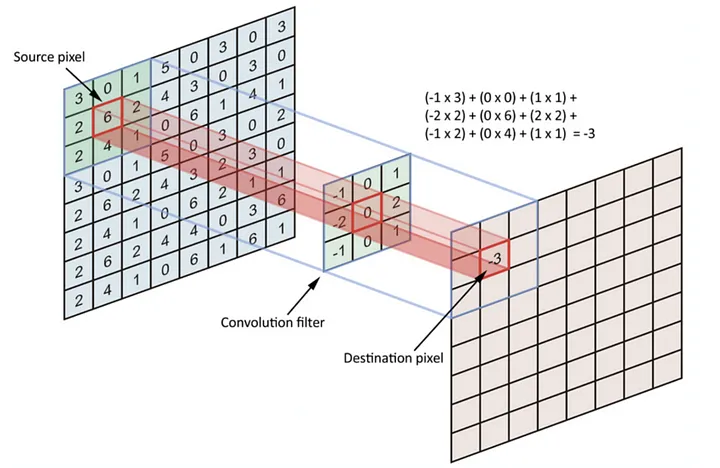

(Source: https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac)

Typically, so-called __convolutional layers__ alternate with __(max) pooling layers__, and several of these layer pairs are stacked together. Thereby, the image size is reduced from layer to layer, while the depth (= number of kernels) is increased. At the end of the CNN stack, one adds one or more Multi-Layer Perceptron (MLP) layers to generate the desired output, for example an image classification label.

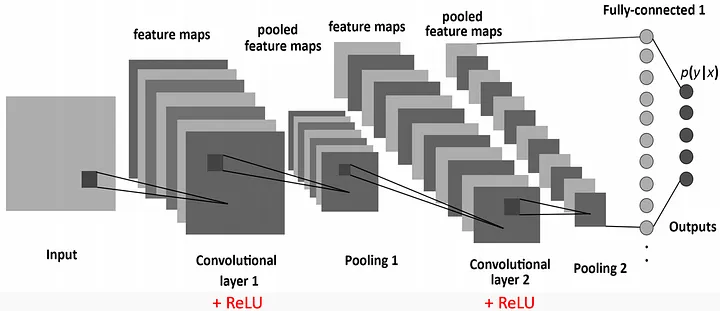

(Source: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

Several variants of CNNs have been developed, for example __inception block__ architectures, where several CNN stacks with different kernel sizes are placed side-by-side to capture information from different distances to the respective center pixel. Another, very prominent example are [__ResNet__](https://databasecamp.de/en/ml/resnet-en) models, which add so-called _skip connections_ to the convolutional blocks.

If you consider gridded climate model output to be image-like, then it becomes clear that people have used CNNs and ResNets to learn weather patterns. If you remove one dimension from the images and kernels, you can even apply CNNs to time series problems. In fact, they often work better than e.g. Recurrent Neural Networks (RNNs) or Long Short-Term Memory networks (LSTMs).

#### Encoder-decoder architectures

When you have the chance to work with really large datasets, you will usually find that you don't have labeled data. Thus, you must resort to __unsupervised__ or __self-supervised__ ML approaches. You will make first encounters with such ideas in this exercise, before we explore them in greater depth after the Christmas break.

A rather generic key concept in unsupervised or self-supervised learning is that of __encoder-decoder__ architectures. Here, one stack of neural network layers (often CNNs) with decreasing image sizes and increasing depth is coupled to another stack of neural networks (not necessarily of the same type), where the "encoding process" is reverted, i.e. image size increases again, while the depth is progressively reduced, until you obtain images of the original size at the last layer.

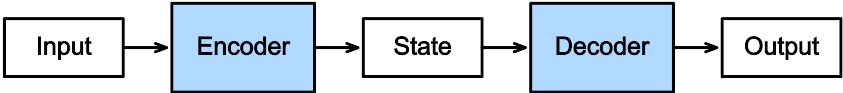

(Source: https://d2l.ai/chapter_recurrent-modern/encoder-decoder.html)

What is the use of this? The point is that, in an unsupervised setting, you are most interested in the central, so-called "bottleneck" layer, which "encodes" a rather abstract representation of your data. To some extent, you could even say that the bottleneck layer is supposed to "understand" the data. By comparing the output after the decoder to the input, you can adjust the weights in the network so that it generates the most faithful reproduction of your data that is possible. Then, after training, you can use this network, for example, to fill holes in the data ("inpainting"), or to remove noise.

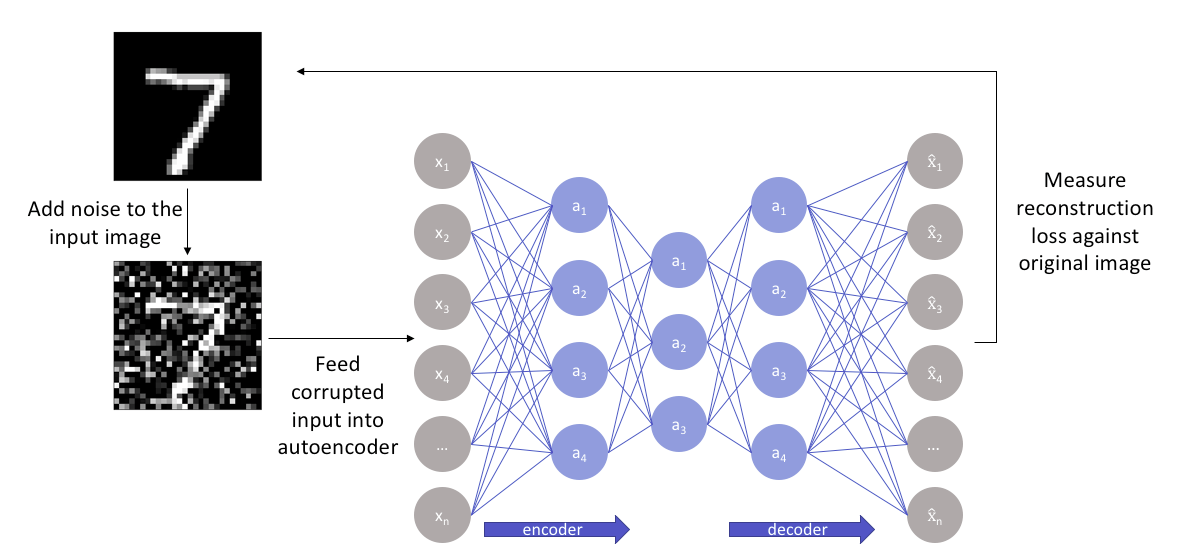

(Source: https://www.v7labs.com/blog/autoencoders-guide)

### U-Net

A U-Net is an encoder-decoder network "bent around". The key innovation of U-Nets, similar to ResNets, is the addition of __skip connections__ between the corresponding layers of the encoder and the decoder. This allows the decoder to incorporate fully-resolved information from the input data into its image generation procedure, and this in turn leads to more realistic images and better predictions.

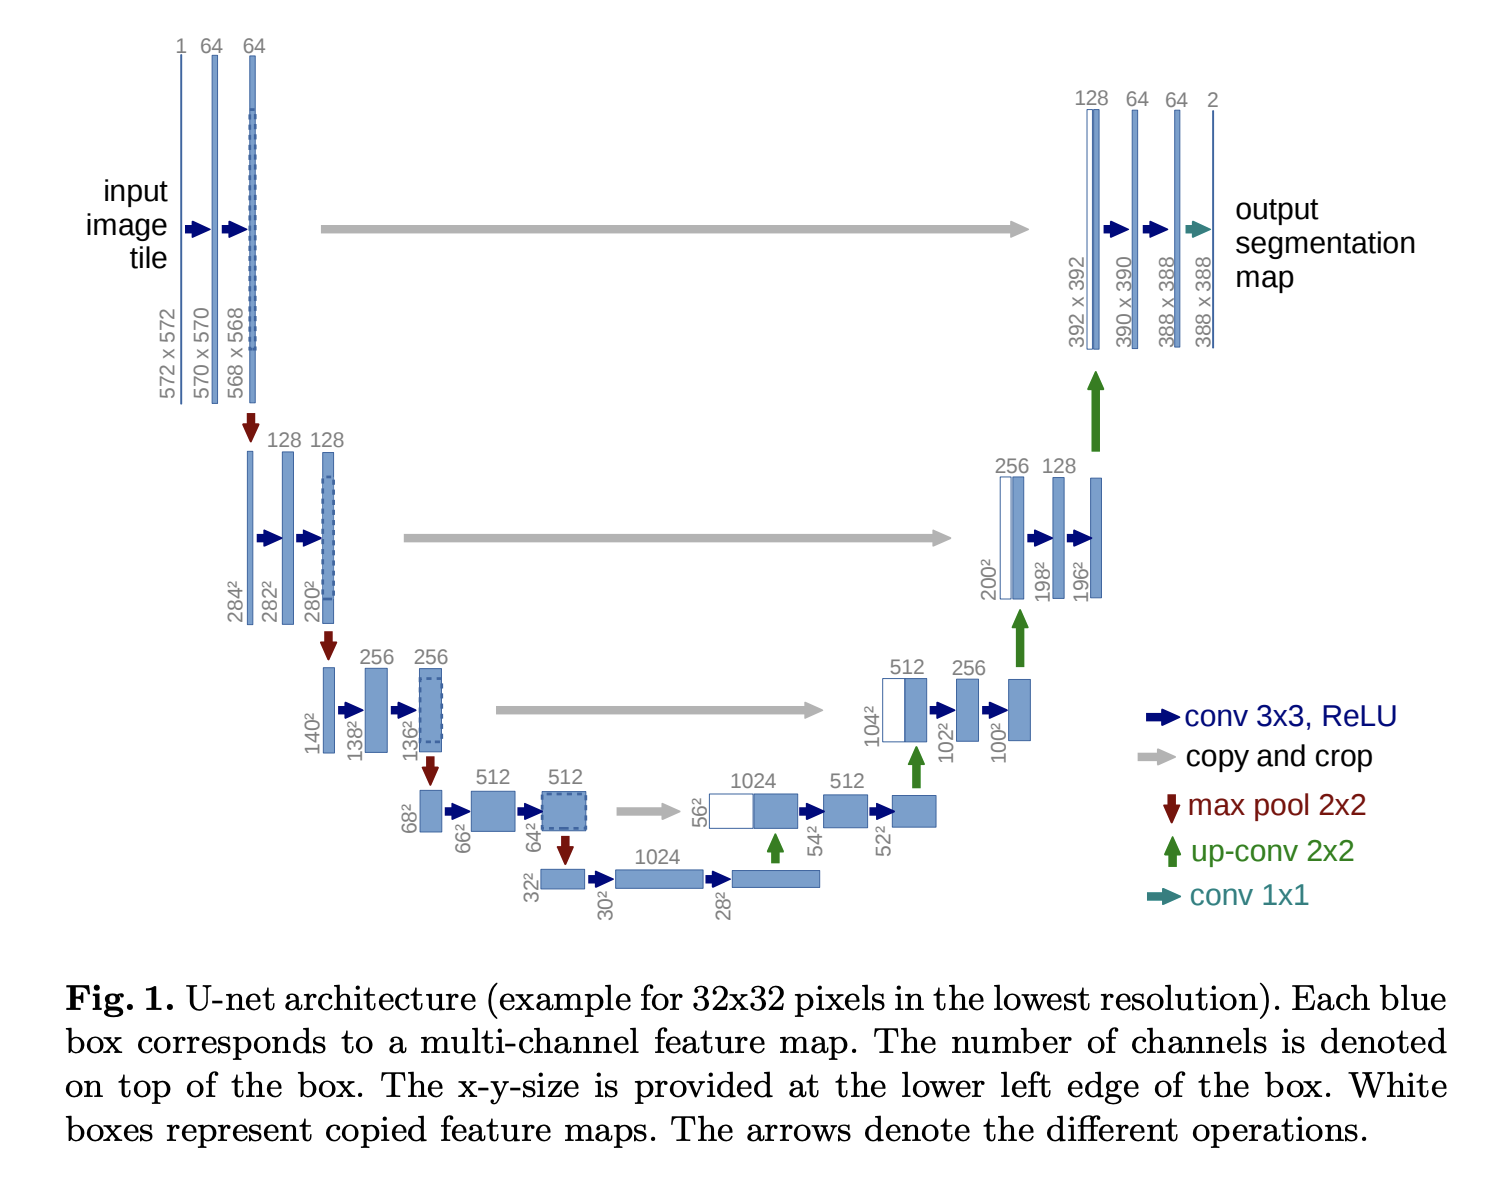

(Source: https://paperswithcode.com/method/u-net)

U-Nets by now find widespread applications in climate and environmental sciences, for example in recent approaches to data-driven weather forecasting. Here, you will use a modified U-Net architecture for your downscaling task.

#### Load Python and the "ML-climate" kernel

As always: if you are working on your own computer, now select the "ML-climate" kernel. This option should exist for you if you followed the Anaconda 3 and subsequent installation instructions provided on Ilias. Alternatively, you can run the notebook on Google Colab. As usual, you will need to use e.g. the Colab data loader whenever files need to be read from the exercise folder, and certain packages might still need to be installed using pip.

In [ ]:
# import packages

import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
import xarray as xr
import datetime as dt
import numpy as np
import scipy
import cftime

#### Load and pre-process the regional climate model data
Let's first load an example CORDEX simulation for surface air temperature ('tas'). 

The high-resolution simulation in this case aimed to reproduce historical surface temperatures over Europe and was driven by observed boundary conditions from the European Centre for Medium Range Weather Forecasting (ECMWF). The model for the simulation was a version of the Met Office Hadley Centre (MOHC) regional atmospheric model.

There is daily average temperature data from 1st January 1982 to 1st December 2012, resulting in 10959 samples. The horizontal size is 64 (rotated longitude) by 48 (rotated latitude), which have extracted for you from a larger output file in advance to make the exercise computationally more manageable. 

However, if you wish to make the exercise computationally more/maximally demanding, we have made the original file with dimensions 424 (rotated longitude) by 412 (rotated latitude) [here](https://bwsyncandshare.kit.edu/s/4ZePjt9cxT7kXWH). **Careful,** this is by no means a standard option and is rather meant for those of you who have their own HPC in their basement (or a nice ssh connection to one...).

In [ ]:
load_file = xr.open_dataset('./data/tas_EUR-11_ECMWF-ERAINT_evaluation_r1i1p1_MOHC-HadREM3-GA7-05_v1_day_19821201-20121201_regional.nc')

In [ ]:
load_file

**Task 1** Select separate training (years 1982-2009), validation (years 2010, 2011) and test data (year 2012) from `original_file` and select the variable `tas` only. For the time slicing, there are many ways but you might find the option `.sel(time=slice('timestamp1', 'timestamp2'))` helpful. If you can't get past this step, ask on the Discussion Board.

Once completed, `print()` the dimensions of each dataset to screen.

In `answer_1` provide a brief reasoning why you would best not shuffle the data before selecting training, validation, and test data.

In [ ]:
ds_train_tas = None
ds_validation_tas = None
ds_test_tas = None
answer_1 =''

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert ds_train_tas is not None
assert ds_validation_tas is not None
assert ds_test_tas is not None
assert len(answer_1) > 0 

In [ ]:
ds_test_tas

#### First visualizations
**Task 2** Use `.isel(time=).plot(vmin=,vmax=,figsize=(6,3),cmap='RdBu_r')` to visualize 2m temperature at the 4th timestep in the training, validation, and test data, respectively, in three separate plots.

What is a major quasi-constant feature in the maps? What might be the cause of this feature? Write your answer to `answer_2`.

In [ ]:
answer_2 = ''
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert len(answer_2) > 0

#### Coarsening

As stated above, the aim of this notebook is to carry out some downscaling with neural networks. Usually, we would do this with separate datasets, perhaps low (input) and high (target) resolution output from a process-based climate model.

Here we artificially create a lower resolution version of this data by using the `xarray.coarsen` method, followed by nearest neighbour interpolation to return the data to the same dimensions. This halves the resolution of the data in both the longitude and latitude dimensions. 

In [ ]:
print('train shape before coarsening: ',ds_train_tas.shape)
print('validation shape before coarsening: ',ds_validation_tas.shape)
print('test shape before coarsening: ',ds_test_tas.shape)
ds_train_tas_coarse = ds_train_tas.coarsen(rlon=2, rlat=2, boundary='exact').mean()
ds_validation_tas_coarse = ds_validation_tas.coarsen(rlon=2, rlat=2, boundary='exact').mean()
ds_test_tas_coarse = ds_test_tas.coarsen(rlon=2, rlat=2, boundary='exact').mean()
print('train shape after coarsening: ',ds_train_tas_coarse.shape)
print('validation shape after coarsening: ',ds_validation_tas_coarse.shape)
print('test shape after coarsening: ',ds_test_tas_coarse.shape)
# NB: there are alternative options for what to do at the boundary.
#dsf_train_tas_coarse = ds_train_tas.coarsen(rlon=4, rlat=4, boundary='pad').mean()
#dsf_validation_tas_coarse = ds_validation_tas.coarsen(rlon=4, rlat=4, boundary='pad').mean()
#dsf_test_tas_coarse = ds_test_tas.coarsen(rlon=4, rlat=4, boundary='pad').mean()

For easy comparison later, we now return the dimensions of the coarsened data to the same dimensions as the high resolution data.

To do this we interpolate with nearest neighbour interpolation.

Note that we could change the architecture of the network below to deal with the different dimensions, but comparing the fields is made easier by having them in the same dimensions.

In [ ]:
ds_train_tas_coarse = ds_train_tas_coarse.interp_like(ds_train_tas, method="nearest")
ds_validation_tas_coarse = ds_validation_tas_coarse.interp_like(ds_validation_tas, method="nearest")
ds_test_tas_coarse = ds_test_tas_coarse.interp_like(ds_test_tas, method="nearest")

#### Let's have a look at this data - what do we notice?
As you can see, the resolution has significantly decreased.

In addition, along the boundary of the domain, we have introduced nans...as a quick fix, we set those values to the average.

In [ ]:
ds_train_tas.isel(time=0).plot(vmin=250,vmax=285,figsize=(6,3),cmap='RdBu_r')
ds_train_tas_coarse.isel(time=0).plot(vmin=250,vmax=285,figsize=(6,3),cmap='RdBu_r')

In [ ]:
ds_train_tas.isnull().sum(), ds_train_tas_coarse.isnull().sum()

In [ ]:
# set nans to the mean value - not perfect!

ds_train_tas = ds_train_tas.fillna(ds_train_tas.mean())
ds_train_tas_coarse = ds_train_tas_coarse.fillna(ds_train_tas.mean())

ds_validation_tas = ds_validation_tas.fillna(ds_train_tas.mean())
ds_validation_tas_coarse = ds_validation_tas_coarse.fillna(ds_train_tas.mean())

ds_test_tas = ds_test_tas.fillna(ds_train_tas.mean())
ds_test_tas_coarse = ds_test_tas_coarse.fillna(ds_train_tas.mean())

#### Data Normalization 
As discussed repeatedly in the lectures and previous worksheets, in machine learning, not every dataset requires normalization. However, normalization is often required when the input variables have different ranges, especially for training neural networks. So, we need to bring all the variables to the same range. 

There are several ways to normalize the dataset. Min-max scaler and standardization are two of the most widely used approaches.

*   Min-Max Scaler:  the data is scaled to a fixed range — usually 0 to 1.
($X_{norm} = \frac{X- X_{min}}{X_{max} - X_{min}}$)
*   Standardization: The data is normalized to a Z-score, or standard score. $X_{norm} = \frac{X-\mu}{\sigma}$

Where ${\mu}$ is the mean values of $X$ and ${\sigma}$ is the standard deviation of $X$.

For 2-metre temperature downscaling, we will normalize the dataset with Z-score to ease the deep learning training procedure. Here, we have prepared the function `normalize_data` for this task.

In [ ]:
# Function to normalise the data

def normalize_data(data, mu=None, std=None, dims=None):
    '''
    Normalize the data in an xarray dataset
    '''
    
    if mu is None and std is None:
        if not dims:
            dims = list(data.dims)
        
        mu = data.mean(dim=dims)
        std = data.std(dim=dims)
        
    data_out = (data-mu)/std
    
    return data_out, mu, std


**Task 3** Use the function `normalize_data` to normalize the training, validation, and test data. Make sure to follow principles you have learned in the lectures and previous exercises. Do this both for the original and coarsened datasets. After normalization refer to the coarse data with the label `_input` and to the high-resolution data as `_target`.

In [ ]:
# normalize datasets and write them (following logical associations) 
# to the initialized variables below
t2m_input_train = None
t2m_target_train = None
t2m_input_validation = None
t2m_target_validation = None
t2m_input_test = None
t2m_target_test = None
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# Look at the original statistics - do these look about right?

print('mu of input 2m-temperature is {}'.format(t2m_input_train_mu.values))
print('std of input 2m-temperature is {}'.format(t2m_input_train_std.values))

# And how about the normalized data statistics?

print('mu of normalized input 2m-temperature is {}'.format(t2m_input_train.mean()))
print('std of normalized input 2m-temperature is {}'.format(t2m_input_train.std()))

In [ ]:
# How different are the mean and std values of the unnormalized 
# and normalized validation and test dataset?
print('Validation, unnormalized:')
print(ds_validation_tas_coarse.mean(), ds_validation_tas_coarse.std())
print('Validation, normalized:')
print(t2m_input_validation.mean(), t2m_input_validation.std())
print('Test, unnormalized:')
print(ds_test_tas_coarse.mean(), ds_test_tas_coarse.std())
print('Test, normalized:')
print(t2m_input_test.mean(), t2m_input_test.std())

#### Prepare data for U-Net

In [ ]:
# Could include other images of variables here, hence we use concat 
# in case we wanted to include another variable.
input_train_data = xr.concat([t2m_input_train], dim="variable")
target_train_data = xr.concat([t2m_target_train], dim="variable")
input_validation_data = xr.concat([t2m_input_validation], dim="variable")
target_validation_data = xr.concat([t2m_target_validation], dim="variable")
input_test_data = xr.concat([t2m_input_test], dim="variable")
target_test_data = xr.concat([t2m_target_test], dim="variable")
# Sometimes, depending on your neural network, you might need to re-order the 
# data shape to match the input shape of the neural network. 
# In our UNet architecture, the input shape is required to be 
# ('time', 'lat', 'lon', 'variable')
input_train_data  = input_train_data.transpose("time", "rlat", "rlon", "variable")
target_train_data = target_train_data.transpose("time", "rlat", "rlon", "variable")
print('input data dims are {}'.format(input_train_data.dims))
print('target data dims are {}'.format(target_train_data.dims))
input_validation_data  = input_validation_data.transpose("time", "rlat", "rlon","variable")
target_validation_data = target_validation_data.transpose("time", "rlat", "rlon", "variable")
print('input data dims are {}'.format(input_validation_data.dims))
print('target data dims are {}'.format(target_validation_data.dims))
input_test_data  = input_test_data.transpose("time", "rlat", "rlon", "variable")
target_test_data = target_test_data.transpose("time", "rlat", "rlon", "variable")
print('input data dims are {}'.format(input_test_data.dims))
print('target data dims are {}'.format(target_test_data.dims))

#### **Build the U-Net**

We will now build and train the U-Net architecture proposed by [Sha et al.,2020](https://journals.ametsoc.org/view/journals/apme/59/12/jamc-d-20-0057.1.xml). As explained there, the U-Net consists of a constraction path (encoder, left branch in the Figure below) and an expanding path (decoder, right branch). The encoder consists of a stack convolutional blocks and max pooling layers. Numbers beside the dark-blue boxes represent the number of convolutional channels. Yellow and red boxes are the maximum pooling and unpooling layers (for upsampling in the decoder), respectively. Transparent boxes with dashed lines represent layer concatenations (cf. skip connections). The gray axis on the right displays the level of downsampling (attention - not "downscaling"!). The double slash represents the optional spatial dropout for regularization. Light-blue, green, and red background colors highlight the hidden layers as part of the downsampling, bottom-level nonlinear mapping, and upsampling blocks, respectively. The HR elevation (another variable that we could use here as well, but we won't) output branch of UNet-AE is shown within the gray background.

Note the typo in their figure! (a good reminder to always check your figures carefully before submitting final proofs of your publications)

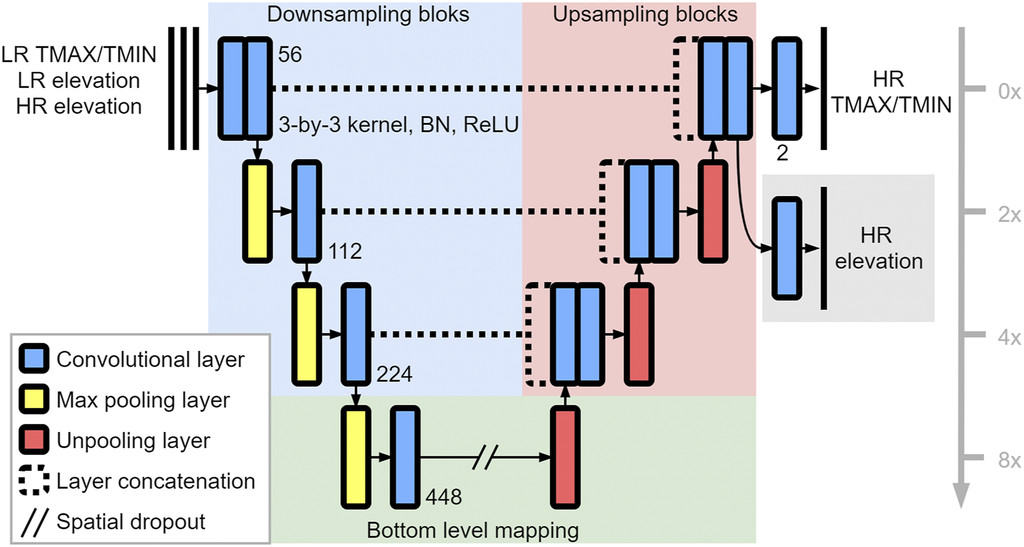

We will first need to define some auxilliary functions for the building blocks of the model architecture.

Then we will start with the encoder and to build a convolutional block (box in blue color). **Try to understand each part of the code.**

Each convolutional block comprises of:

1.   convolutional layers with a kernel size of 3x3
2.   a batch normalization layer, and 
3.   Rectified linear unit (ReLU) activation function

All the layers can be simply implemented with the functions `Conv2D` , `BatchNormalization` and `Activation` using `Keras`.

In [ ]:
# import tensorflow and required modules from Keras API
import tensorflow as tf
import tensorflow.keras.utils as ku
# all the layers used for U-net
from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Conv2D,
                                     Conv2DTranspose, Input, MaxPool2D)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
def conv_block(inputs, num_filters: int, kernel: tuple = (3,3), padding: str = "same",
               activation: str = "relu", kernel_init: str = "he_normal", l_batch_normalization: bool = True):
    """
    A convolutional layer with optional batch normalization
    :param inputs: the input data with dimensions nx, ny and nc
    :param num_filters: number of filters (output channel dimension)
    :param kernel: tuple indictating kernel size
    :param padding: technique for padding (e.g. "same" or "valid")
    :param activation: activation function for neurons (e.g. "relu")
    :param kernel_init: initialization technique (e.g. "he_normal" or "glorot_uniform")
    """
    
    x = Conv2D(num_filters, kernel, padding=padding, kernel_initializer=kernel_init)(inputs)
    if l_batch_normalization:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x
    
# In the encoder, each level consists of `N`
# identical convolutional blocks
def conv_block_n(inputs, num_filters, n=2, kernel=(3,3), padding="same", activation="relu", 
                     kernel_init="he_normal", l_batch_normalization=True):
    """
    Sequential application of two convolutional layers (using conv_block).
    """
    
    x = conv_block(inputs, num_filters, kernel, padding, activation,
                   kernel_init, l_batch_normalization)
    for i in np.arange(n-1):
        x = conv_block(x, num_filters, kernel, padding, activation,
                       kernel_init, l_batch_normalization)
    
    return x
    
# Then, max pooling is applied to each convolutional block to decrease the resolution
def encoder_block(inputs, num_filters, kernel_maxpool: tuple=(2,2), l_large: bool=True):
    """
    One complete encoder-block used in U-net
    """
    if l_large:
        x = conv_block_n(inputs, num_filters, n=2)
    else:
        x = conv_block(inputs, num_filters)
        
    p = MaxPool2D(kernel_maxpool)(x)
    
    return x, p
    
# finally, let's define the decoder block
def decoder_block(inputs, skip_features, num_filters, kernel: tuple=(3,3), strides_up: int=2, 
                  padding: str= "same", 
                  activation="relu", kernel_init="he_normal", l_batch_normalization: bool=True):
    """
    One complete decoder block used in U-net (reverting the encoder)
    """
    
    x = Conv2DTranspose(num_filters, (strides_up, strides_up), strides=strides_up, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block_n(x, num_filters, 2, kernel, padding, activation, kernel_init, l_batch_normalization)
    
    return x

**Task 4** Complete the `build_unet` function below. It should consist of 
- three stacked `encoder_block`s: The first block accepts the inputs, and learns `channels_start` kernels, and is built of two sequential convolutional layers. The second block accepts the subsequent feature maps and learns twice as many kernels, and consists of a convolutional layer with batch normalization.  The third block learns four times as many kernels as the first block and also consists of a convolutional layer with batch normalization.
- the encoder is then bridged to the decoder by a `conv_block` with 8 times as many kernels as the first encoder block.
- the decoder part then consists of three `decoder_block`s with four/two/one times `channels_start` kernels, in that order (U-symmetric to the encoder).
- finally, the `output` is created, using another Keras `Conv2D` layer object to perform a 1x1 convolution, see its [documentation here](https://keras.io/api/layers/convolution_layers/convolution2d/), with `he_normal` initialization.

In [ ]:
def build_unet(input_shape, channels_start=56):
    
    inputs = Input(input_shape)
    output = None
# YOUR CODE HERE
raise NotImplementedError()
    model = Model(inputs, output, name="t2m_downscaling_unet")
    
    return model

In [ ]:
# Build the architecture
shape_in = (input_train_data.shape[1], input_train_data.shape[2], 1)
unet_model = build_unet(shape_in)

**Task 5** Now that we have built the U-Net architecture, let's use `.summary` to view the model set-up in compact form. Explain the model structure by writing to `answer_5`. In particular, explain:
- the meaning of each column of the table.
- the idea behind the sequence of model layers (e.g. input, conv2d, activation, max_pooling, batch_normalization)
- the idea behind their layer sizes (number channels).
- which layers receive information via skip connections?
- what the difference between trainable and non-trainable parameters is.

Use the lecture material, search the internet, and the original paper by Sha et al. (2020) to inform your answers.

In [ ]:
answer_5 = '''
'''
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# Build the architecture
# Let's view and summarise your model:
unet_model.summary()

In [ ]:
assert len(answer_5) > 0

#### Train the U-Net

To train the model, we need to specify the optimizer and the loss function, the learning rate, number epochs, the batch size etc. We will below set the hyperparameters for you so that you don't need to re-run an expensive grid search. However, feel free to manually change these parameters to see the effect on the results, see also the optional task at the end. Careful! This is expensive...

The training process can take a while even for a single setting for the hyperparameters (depends on your computer, but on my laptop it took around two hours). If you are not keen to do this, e.g. to let it run over night, you can comment out the next cell and instead load a pre-trained model below.

In [ ]:
# If you run this yourself on your local laptop, you can expect this to take a while 
#(factor in at least two hours depending on your machine)
# If you don't want to run the training of the U-Net yourself, you can 
# comment out this cell and load the model
# we pre-trained below
learning_rate = 5*10**(-2)
batch_size = 64
epochs = 30
unet_model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mae")
history = unet_model.fit(x=input_train_data.values, y=target_train_data.values, 
                         batch_size=batch_size, epochs=epochs, 
                         validation_data=(input_validation_data.values, 
                                          target_validation_data.values))
# save the weights
# there are multiple ways, see e.g. https://stackoverflow.com/questions/47266383/save-and-load-weights-in-keras
# unet_model.save('./models/my_saved_unet_full')
unet_model.save_weights('./models/my_saved_unet_new_run')

In [ ]:
# We can load the weights again as follows:

# Create a new model instance
unet_model_new = build_unet(shape_in)

# Restore the weights
unet_model_new.load_weights('./models/my_saved_unet')

#### Prediction, visualization, and analysis

Now, we have trained our U-net model. Let's have a look at the results. 

The prediction, visualization, and analysis will apply to the separate test dataset you created above.

**Task 6** Use your U-net model or the loaded `unet_model_new` function above to `.predict()` on the input test data. Afterwards transform those predictions back into raw temperature fields by undoing the standard-scaling applied above. Write the latter to the variable initialized as `y_pred_test`.

*Hint:* You can use `.values` to access the pure data in `xarray` (if you receive warnings). To access the standard deviation and mean values from above, you can additionally use `.squeeze()` beforehand.

In [ ]:
y_pred_test_norm = None
y_pred_test = None
# YOUR CODE HERE
raise NotImplementedError()
# finally, turn the predictions that you produced into an xarray again
y_pred_test = xr.DataArray(y_pred_test, coords=ds_test_tas.coords, dims=target_test_data.dims)

In [ ]:
y_pred_test_norm.shape

Now let us visualize the results for a given timestep. For this, we plot the difference between the coarsened image and the truth for a given day, and the difference between the prediction and the ground truth for the same day. 

Did we reconstruct some of the higher resolution pattern?

In [ ]:
# choose the date you would like to plot here! Has to be in the test dataset.
day=5
t2m_in, t2m_tar = ds_test_tas_coarse.isel(time=day), \
                  ds_test_tas.isel(time=day)    
y_pred = y_pred_test.isel(time=day)
# transform units from Kelvin to degree Celcius
t2m_in, t2m_tar, y_pred = t2m_in - 273.15, t2m_tar - 273.15, y_pred - 273.15           
#calculate the differences between t2m_in and t2m_tar
diff_in_tar = t2m_in - t2m_tar 
#calculate the differences between y_pred and t2m_tar
diff_pred_tar =  y_pred - t2m_tar 
diff_in_tar.plot(vmin=-6, vmax=6, figsize=(6, 3),cmap='RdBu_r')
plt.title('Difference between input and target')

diff_pred_tar.plot(vmin=-6, vmax=6, figsize=(6, 3),cmap='RdBu_r')
plt.title('Difference between prediction and target')
# What about some other metrics?
# RMSE
mse_dom = ((ds_test_tas - y_pred_test[...,0])**2).mean(dim=["time","rlat", "rlon"])
rmse_dom = np.sqrt(mse_dom)
mse_dom_before_downscaling = ((ds_test_tas - ds_test_tas_coarse[...,0])**2).mean(dim=["time","rlat", "rlon"])
rmse_dom_before_downscaling = np.sqrt(mse_dom_before_downscaling)
print(f"average RMSE of downscaled 2m temperature: {rmse_dom.values} K.")
print(f"average RMSE of 2m temperature before downscaling: {rmse_dom_before_downscaling.values} K.")

Evidently, the error has been reduced quite significantly (from 8.2 K RMSE to 0.6 K). Of course, the error reduction is most prominent along the in-filled edges of the domain, but also especially in the (lower) right side/South-Eastern corner of the domain where large anomalies are found between the target and the prediction.

However, the improvement is not general. For example, in large parts of the western part of the domain a slight warm bias has been introduced, at least on the days that we visualized for ourselves...so the downscaling as trained doesn't always necessarily lead to improvements everywhere.

**Task 7** (optional): You could explore online GPU computing platforms like [WandB](https://wandb.ai/site) to run a more comprehensive hyperparameter search on the fit above, or simply use computing resources already available to do so.

Below some comments and code snipets you might find useful to get wandb running in conjunction with your Jupyter notebook.

In [ ]:
# ### Sign up on `wandb`
# 1.   Sign up for a free account at https://wandb.ai/site and then login to your wandb account.
# 2.   Login to the wandb library on your machine. You will find your API key here: https://wandb.ai/authorize. 

#import wandb
#from wandb.integration.keras import WandbCallback  
#If you are using GPUs node here there is Internet connection for training, 
# WANDB_MODE=offline is needed, then sync your runs from another machine (log in node) with an internet connection
#import os
#os.environ["WANDB_MODE"]="offline"

#If you train your network on login node with internet connection, you can sync your runs to wandb server. 
#log in wandb
#wandb.login()
### Start a new run:
### Initialize a new run in W&B in your Python script or notebook. wandb.init() will start tracking system metrics and console logs
 # Initilize a new wandb run

#wandb_dir = f"/{os.environ['USER']}"              

#wandb.init(dir=wandb_dir)
# overwrite the run name (like snowy-owl-10) with the run ID thata you can use this snippet
#wandb.run.name = f"{os.environ['USER']}" + "test2"

### Default values for *hyper-parameters*, *if we use WandB*
#config = wandb.config # Config is a variable that holds and saves hyperparameters and inputs
#config.learning_rate = 5*10**(-2)
#config.batch_size = 32
#config.epochs = 30
# wandb.finish()